__packages necessary:__ (comment out if done through terminal)

In [1]:
#!pip install --upgrade pip setuptools
%pip install numba==0.60.0 llvmlite==0.43.0 --user 
%pip install pandas==2.2.2
%pip install tqdm==4.67.1
%pip install scikit-learn==1.6.1
%pip install torch
%pip install tensorflow==2.18.0
%pip install alibi==0.9.6 

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


__Necessary imports:__

In [2]:
import pandas as pd
import numpy as np
import time

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from alibi.explainers import AnchorTabular
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import ParserError
import string

c:\Users\jespe\Apps\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\jespe\Apps\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Anchor explanations

__Code for anchor explanation using text of the title example: (not used in report)__

In [4]:
from pandas.errors import ParserError
# Start timer
start_time = time.time()

# Load and sample dataset early to save memory
try:
    df = pd.read_csv('WELFake_Dataset.csv', engine='python')
except ParserError:
    # skip lines causing errors ( this will only be a couple of instances)
    print("ParserError encountered with python engine, trying to skip bad lines.")
    df = pd.read_csv('WELFake_Dataset.csv', engine = 'python', on_bad_lines='skip')
#df = pd.read_csv('WELFake_Dataset.csv')
df = df.dropna(subset=['title', 'text', 'label'])

# Sample smaller subset for speed/memory
df = df.sample(n=1500, random_state=42).reset_index(drop=True)

# Limit to first 150 words per article to shorten input length
df['text'] = df['text'].apply(lambda x: ' '.join(str(x).split()[:150]))
#df['title'] = df['title'].apply(lambda x: ' '.join(str(x).split()[:150]))

# Extract features and labels
X = df['text'].values
y = df['label'].values

# Vectorize text
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_vec = vectorizer.fit_transform(tqdm(X, desc="Vectorizing"))

# Train-test split

original_indices = np.arange(len(X)) # this allows to track original indices before split
X_train, X_test, y_train, y_test, train_idx, test_idx= train_test_split(X_vec, y, original_indices, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prepare input for explanation
X_dense = X_vec.toarray()
X_test_dense = X_test.toarray()

index_to_explain = 4
instance = X_test_dense[index_to_explain].reshape(1, -1)
true_index = test_idx[index_to_explain]


predict_fn = lambda x: clf.predict(x)

# Anchor explanation
feature_names = vectorizer.get_feature_names_out()
class_names = ['real', 'fake']

explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_dense[:500])

print(f"True class: {class_names[int(y_test[index_to_explain])]}")
print(f"Title of explained instance: {df.loc[true_index, 'title']}")
print('\nPrediction:(0 = real news, 1=  fake news): ', predict_fn(instance)[0])
#print('\nPrediction:(0 = real news, 1=  fake news): ', clf.predict(instance)[0])

explanation = explainer.explain(
    instance,
    coverage_samples=100,
    beam_size=3,
    max_anchor_size=7,
    stop_on_first=True
)

print(f"\nAnchor: {explanation.anchor}")
print(f"Precision: {explanation.precision}")
print(f"Coverage: {explanation.coverage}")

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")


ParserError encountered with python engine, trying to skip bad lines.


Vectorizing: 100%|██████████| 1500/1500 [00:00<00:00, 11824.13it/s]


True class: fake
Title of explained instance: MI Election Recount Nightmare: “Write-In” Votes For Bernie In Detroit Were Being Counted As Votes For Hillary…And More

Prediction:(0 = real news, 1=  fake news):  1

Anchor: ['said <= 0.00', 'com > 0.00', 'democrats <= 0.00']
Precision: 0.9689119170984456
Coverage: 0.07

Total time taken: 67.87 seconds


__code for Anchor explainer that explains predictions based on titles (used in report):__

In [ ]:
# Extract features and labels
X = df['title'].values
y = df['label'].values

# Vectorize text
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_vec = vectorizer.fit_transform(tqdm(X, desc="Vectorizing"))

# Train-test split
original_indices = np.arange(len(X)) # this allows to track original indices before split
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X_vec, y, original_indices, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prepare input for explanation
X_dense = X_vec.toarray()
X_test_dense = X_test.toarray()


index_to_explain = 4
#instance = X_dense[index_to_explain].reshape(1, -1)
instance = X_test_dense[index_to_explain].reshape(1, -1)
true_index = test_idx[index_to_explain]

predict_fn = lambda x: clf.predict(x)

# Anchor explanation
feature_names = vectorizer.get_feature_names_out()
class_names = ['real', 'fake']

explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_dense[:500])

print(f"True class: {class_names[int(y_test[index_to_explain])]}")
print(f"Title of explained instance: {df.loc[true_index, 'title']}")
print('\nPrediction:(0 = real news, 1=  fake news): ', predict_fn(instance)[0])

explanation = explainer.explain(
    instance,
    coverage_samples=100,76
    beam_size=3,
    max_anchor_size=7,
    stop_on_first=True
)

print(f"\nAnchor: {explanation.anchor}")
print(f"Precision: {explanation.precision}")
print(f"Coverage: {explanation.coverage}")

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

Vectorizing: 100%|██████████| 1500/1500 [00:00<00:00, 61396.83it/s]


True class: fake
Title of explained instance: MI Election Recount Nightmare: “Write-In” Votes For Bernie In Detroit Were Being Counted As Votes For Hillary…And More

Prediction:(0 = real news, 1=  fake news):  1

Anchor: ['breitbart <= 0.00', 'bernie > 0.00']
Precision: 1.0
Coverage: 0.02

Total time taken: 232.96 seconds


# Attention-maps / attention based explanations:

__Code for training and plot of attention for example sentence__

ParserError encountered with python engine, trying to skip bad lines.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 (tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 1.0170,  0.9652, -0.2520,  ..., -0.3816,  0.7396,  0.6605],
         [ 0.4916, -0.2606,  0.5653,  ...,  0.7518, -0.2280,  0.1384],
         ...,
         [-0.3072,  0.6288, -0.1718,  ...,  0.4260,  0.5675,  0.5275],
         [ 0.5235,  0.6732, -0.1521,  ..., -1.1120,  0.8231, -0.6102],
         [-0.5129,  0.0944,  0.0777,  ..., -0.7099,  0.1934, -0.2207]]],
       grad_fn=<NativeLayerNormBackward0>), tensor([[[ 1.2171e-01,  9.6526e-03, -1.4177e-01,  ...,  6.0990e-02,
           4.7099e-02,  2.5192e-02],
         [ 1.0974e+00,  3.3282e-01, -5.8724e-01,  ..., -2.7913e-01,
           8.5187e-01,  1.1771e+00],
         [ 5.5519e-01, -7.2058e-04,  5.9903e-01,  ...,  3.7075e-01,
           2.0139e-01,  1.6845e-01],
         ...,
         [-1.3975e-01,  5.2967e-01, -2.8912e-01,  ...,  4.2091e-01,
           2.5050e-01,  4.1035e-01],
         [ 6.5404e-01,  4.8104e-01, -4.0532e-01,  ..., -1.3729e+00,
         

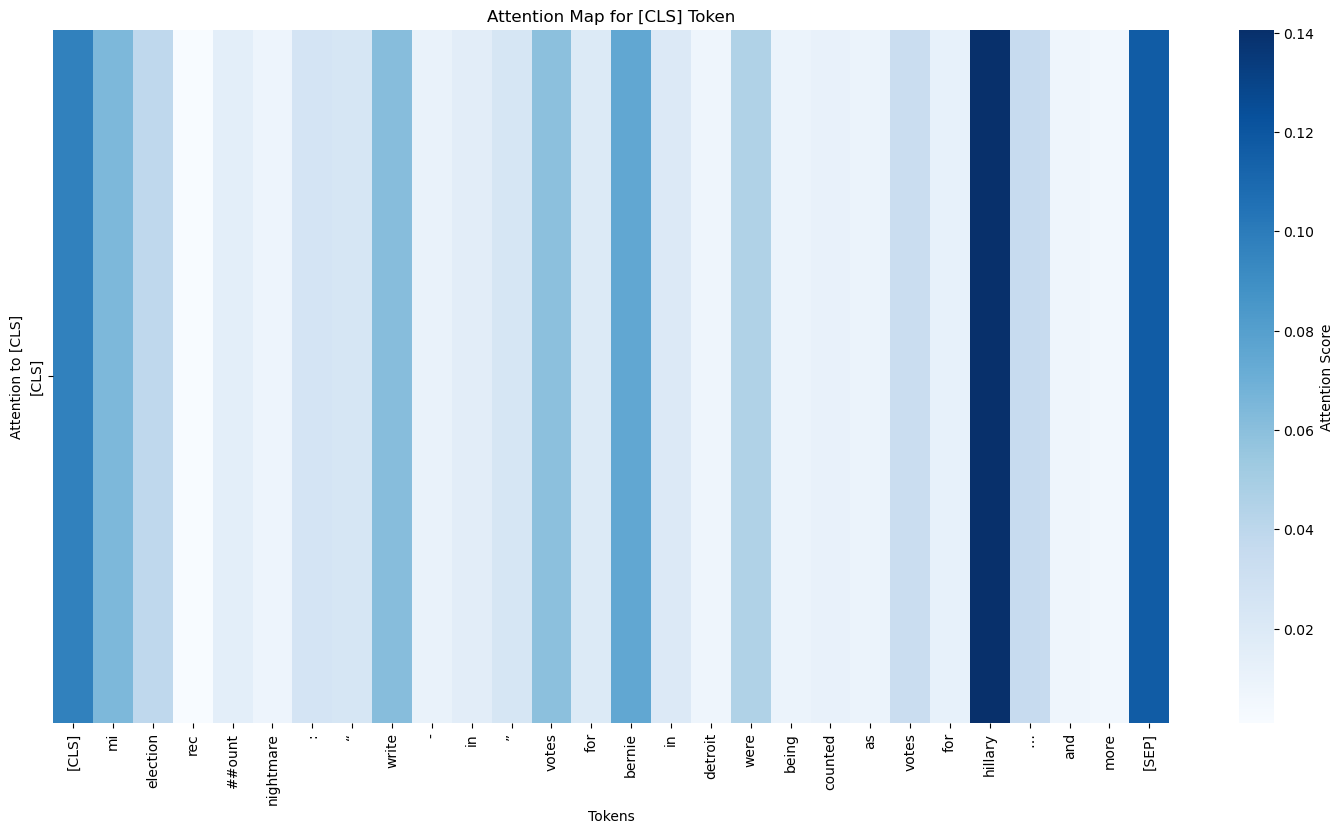

According to the dataset, this post inclucded or was fake news
example prediction: fake


In [6]:
# This model (bert-base-uncased) is not trained for prediction, so it just shows a random prediction and the output weights of the hidden state of the model ( which just represents how much semantical weight words have)
# this is not an accurate representation of the attention the model would have for prediction of real vs fake, but it does show what a visualisation of attention of real vs fake news classification would look like
# an attention-based explanation would look like. ( we can use the visualisation as demonstration of how it aligns with human intuition, therefore I still used it)
#
from transformers import BertConfig

try:
    df = pd.read_csv('WELFake_Dataset.csv', engine='python')
except ParserError:
    # skip lines causing errors ( this will only be a couple of instances)
    print("ParserError encountered with python engine, trying to skip bad lines.")
    df = pd.read_csv('WELFake_Dataset.csv', engine = 'python', on_bad_lines='skip')
   
    
df = df.dropna(subset=['title', 'text', 'label'])  # make sure no missing data

df = df.sample(n=1500, random_state=42).reset_index(drop=True) # not necessary for this method, but still done so explanation can be shown for the same example instance

X = df['title'].values
y = df['label'].values  # assume binary: 1 = fake, 0 = real

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

index_explained_text = 4
text_to_explain = X_test[index_explained_text]
text_to_explain = text_to_explain[:1500] # limits long title to max length


config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states = True, output_attentions = True)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config = config)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

text = text_to_explain # makesit so

# Tokenize and pass through model
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)

logits = outputs.logits  # Raw prediction scores
predicted_class = torch.argmax(logits, dim=1).item()


last_hidden_states = outputs.hidden_states
print("\n",last_hidden_states)

# Getting attention maps
attention = outputs.attentions  # List of layers with attention weights
attention_map = attention[-1][0]  # Last layer's attention for first head

# Visualizing attention to [CLS] token
cls_attention = attention_map[0][0].detach().numpy()
print(cls_attention)  # Attention scores from [CLS] to each token



# Prepare tokens for labeling
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])


#Plots the attention map to visualize how much the model attends to the [CLS] token
plt.figure(figsize=(18, 9))
sns.heatmap(cls_attention.reshape(1, -1), cmap='Blues', cbar_kws={'label': 'Attention Score'}, xticklabels=tokens, yticklabels=["[CLS]"], cbar=True)
#sns.heatmap(cls_attention.reshape(1, -1),cmap = 'YlOrBr', cbar_kws={'label': 'Attention Score'}, xticklabels=tokens, yticklabels=["[CLS]"], cbar=True)
plt.title('Attention Map for [CLS] Token')
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Attention to [CLS]')
plt.show()


#print("Label:", "fake" if y_test[index_explained_text] == 1 else "real")
if y_test[index_explained_text] == 0:
    print("according to the dataset, this post included or was real news")
else:
    print("According to the dataset, this post inclucded or was fake news")
print("example prediction:", "fake" if predicted_class == 1 else "real")

__Code for visualisation of example sentence used in report(sorted by attention to [CLS])__

In [7]:
filtered_token_scores = []
attention_new = cls_attention.copy()

for i, token in enumerate(tokens):
  if token in string.punctuation: # punctuation marks are just biased and show up in every text
    continue
  filtered_token_scores.append((token, attention_new[i]))

sorted_tokens = sorted(filtered_token_scores, key=lambda x: x[1], reverse=True)

#Formatting print to look like table
print(f"sorted attention scores from [CLS] token:\n")
print(f"{'Token':<15} {'Score'}")
print("-" * 25) # for structure to separate scores and variables
for token, score in sorted_tokens:
      print(f"{token:<15} {score:.4f}")

sorted attention scores from [CLS] token:

Token           Score
-------------------------
hillary         0.1405
[SEP]           0.1167
[CLS]           0.0973
bernie          0.0751
mi              0.0647
write           0.0614
votes           0.0597
were            0.0457
election        0.0389
…               0.0355
votes           0.0337
”               0.0245
“               0.0244
in              0.0204
for             0.0201
in              0.0162
##ount          0.0151
for             0.0122
counted         0.0115
as              0.0096
being           0.0094
nightmare       0.0081
detroit         0.0080
and             0.0078
more            0.0055
rec             0.0011


__